In [1]:
!pip install torchinfo

In [2]:
import random
from pathlib import Path
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import PIL
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Подключение Google-диска для загрузки датасета и сохранения весов
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# фиксация SEED
SEED = 42
RANDOM_STATE = SEED
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

ROOT_DIR = Path('/content/')
DATA_DIR = Path('/content/drive/MyDrive/NST_Bot')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device = {device}\n")

!nvidia-smi

Current device = cuda

Sun Jan 28 07:18:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--

In [4]:
# Распаковываем архив с датасетом, скачанный отсюда http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html
!tar -C /content -xf /content/drive/MyDrive/101_ObjectCategories.tar

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """ Imshow для тензоров """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

def image_converter(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [6]:
class ImageDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        # LabelEncoding
        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        # загружаем изображение, ресайз до нужного размера длинной стороны,
        # к короткой стороне изображения добавляем паддинг
        image = Image.open(file).convert('RGB')
        image.load()
        image = PIL.ImageOps.pad(image, (RESCALE_SIZE, RESCALE_SIZE))
        return image

    def __getitem__(self, index):
        # Преобразование изображений в тензоры PyTorch, нормализации входа
        # и три аугментации для train данных
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.RandomRotation(degrees=5),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)

        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

In [7]:
MAIN_DIR = Path('/content/101_ObjectCategories')
RESCALE_SIZE = 224

all_files = list(MAIN_DIR.rglob('*.jpg'))
all_labels = [path.parent.name for path in all_files]

train_files, val_files = train_test_split(all_files, test_size=0.2, \
                                          stratify=all_labels)

train_dataset = ImageDataset(train_files, mode='train')
val_dataset = ImageDataset(val_files, mode='val')

# Количество классов в данных
n_classes = len(np.unique(all_labels))
print(f'Количество классов в датасете Caltech101 = {n_classes}')

print(f'Всего файлов: {len(all_files)} =>  для обучения: {len(train_files)}, для валидации: {len(val_files)}')

Количество классов в датасете Caltech101 = 102
Всего файлов: 9144 =>  для обучения: 7315, для валидации: 1829


In [8]:
def create_dct(files, labels):
    """ Балансировка данных """
    # Формируем словарь с количеством картинок для каждого класса
    dct_images = {}
    for label in np.unique(all_labels).tolist():
        dct_images[label] = []

    for path, label in zip(files, labels):
        dct_images[label].append(path)

    return dct_images

dct_label_paths = create_dct(train_dataset.files, train_dataset.labels)

# Если картинок меньше 100, то размножаем пути для класса
min_number = 100
for label in dct_label_paths:
    if len(dct_label_paths[label]) < min_number:
        dct_label_paths[label] = dct_label_paths[label] * (min_number // len(dct_label_paths[label]))
        dct_label_paths[label].extend(dct_label_paths[label][:min_number - len(dct_label_paths[label])])

new_train_files = []

for label in dct_label_paths:
    new_train_files.extend(dct_label_paths[label])

train_dataset = ImageDataset(new_train_files, mode='train')
print(f"{len(train_files)} => {len(new_train_files)}")

7315 => 12201


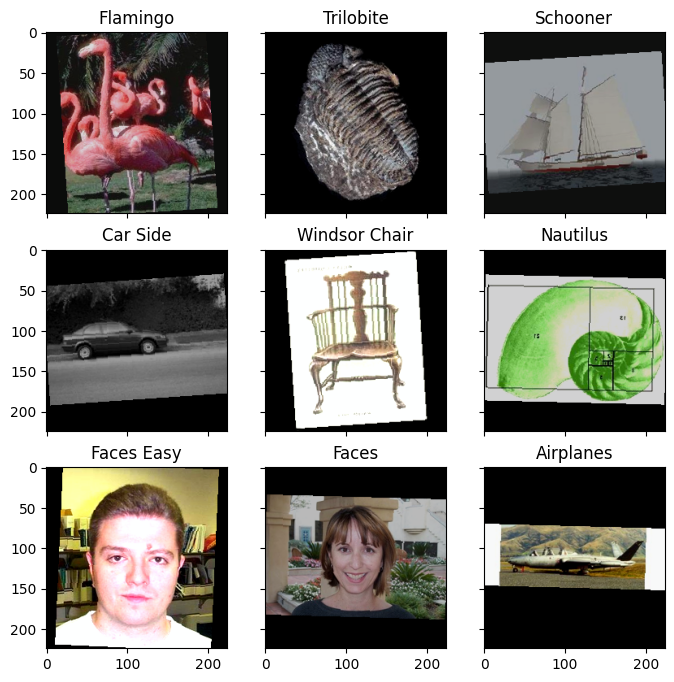

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(train_dataset)))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), img_label, plt_ax=fig_x)

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "Epoch {ep:03d}  train_loss: {t_loss:0.4f}  val_loss: {v_loss:0.4f}\
    train_acc: {t_acc:0.4f}  val_acc: {v_acc:0.4f}\n"

    opt = torch.optim.AdamW(model.parameters(),lr=1e-4, betas=(0.5, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

        val_loss, val_acc = eval_epoch(model, val_loader, criterion)

        history.append((train_loss, train_acc, val_loss, val_acc))

        print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        scheduler.step()

    return history

In [11]:
# Load VGG19 Skeleton and Weights
vgg19 = models.vgg19(weights=True, progress=True)
vgg19.classifier[-1] = nn.Linear(4096, n_classes)
vgg19 = vgg19.to(device)
summary(vgg19, (64, 3, 128, 128)) # B,C,H,W

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 51.2MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 102]                 --
├─Sequential: 1-1                        [64, 512, 4, 4]           --
│    └─Conv2d: 2-1                       [64, 64, 128, 128]        1,792
│    └─ReLU: 2-2                         [64, 64, 128, 128]        --
│    └─Conv2d: 2-3                       [64, 64, 128, 128]        36,928
│    └─ReLU: 2-4                         [64, 64, 128, 128]        --
│    └─MaxPool2d: 2-5                    [64, 64, 64, 64]          --
│    └─Conv2d: 2-6                       [64, 128, 64, 64]         73,856
│    └─ReLU: 2-7                         [64, 128, 64, 64]         --
│    └─Conv2d: 2-8                       [64, 128, 64, 64]         147,584
│    └─ReLU: 2-9                         [64, 128, 64, 64]         --
│    └─MaxPool2d: 2-10                   [64, 128, 32, 32]         --
│    └─Conv2d: 2-11                      [64, 256, 32, 32]         29

In [12]:
history = train(train_dataset, val_dataset, vgg19, epochs=50, batch_size=64)

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 001  train_loss: 1.2169  val_loss: 0.4482    train_acc: 0.7064  val_acc: 0.8775



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 002  train_loss: 0.2738  val_loss: 0.3797    train_acc: 0.9224  val_acc: 0.9065



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 003  train_loss: 0.1434  val_loss: 0.2288    train_acc: 0.9594  val_acc: 0.9344



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 004  train_loss: 0.0866  val_loss: 0.3122    train_acc: 0.9746  val_acc: 0.9267



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 005  train_loss: 0.0571  val_loss: 0.2786    train_acc: 0.9844  val_acc: 0.9366



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 006  train_loss: 0.0350  val_loss: 0.2485    train_acc: 0.9902  val_acc: 0.9349



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 007  train_loss: 0.0257  val_loss: 0.2550    train_acc: 0.9921  val_acc: 0.9404



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 008  train_loss: 0.0232  val_loss: 0.2656    train_acc: 0.9936  val_acc: 0.9371



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 009  train_loss: 0.0173  val_loss: 0.2392    train_acc: 0.9952  val_acc: 0.9426



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 010  train_loss: 0.0172  val_loss: 0.2638    train_acc: 0.9955  val_acc: 0.9366



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 011  train_loss: 0.0136  val_loss: 0.2362    train_acc: 0.9961  val_acc: 0.9448



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 012  train_loss: 0.0101  val_loss: 0.2749    train_acc: 0.9967  val_acc: 0.9388



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 013  train_loss: 0.0093  val_loss: 0.3163    train_acc: 0.9966  val_acc: 0.9377



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 014  train_loss: 0.0077  val_loss: 0.2739    train_acc: 0.9980  val_acc: 0.9399



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 015  train_loss: 0.0060  val_loss: 0.2547    train_acc: 0.9984  val_acc: 0.9442



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 016  train_loss: 0.0048  val_loss: 0.2716    train_acc: 0.9987  val_acc: 0.9470



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 017  train_loss: 0.0022  val_loss: 0.2870    train_acc: 0.9990  val_acc: 0.9464



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 018  train_loss: 0.0033  val_loss: 0.2822    train_acc: 0.9989  val_acc: 0.9492



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 019  train_loss: 0.0029  val_loss: 0.2696    train_acc: 0.9992  val_acc: 0.9492



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 020  train_loss: 0.0015  val_loss: 0.2583    train_acc: 0.9995  val_acc: 0.9513



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 021  train_loss: 0.0013  val_loss: 0.2541    train_acc: 0.9997  val_acc: 0.9546



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 022  train_loss: 0.0011  val_loss: 0.2672    train_acc: 0.9997  val_acc: 0.9513



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 023  train_loss: 0.0011  val_loss: 0.2722    train_acc: 0.9996  val_acc: 0.9519



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 024  train_loss: 0.0017  val_loss: 0.2879    train_acc: 0.9993  val_acc: 0.9464



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 025  train_loss: 0.0013  val_loss: 0.2749    train_acc: 0.9995  val_acc: 0.9497



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 026  train_loss: 0.0017  val_loss: 0.2771    train_acc: 0.9994  val_acc: 0.9497



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 027  train_loss: 0.0014  val_loss: 0.2709    train_acc: 0.9993  val_acc: 0.9486



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 028  train_loss: 0.0012  val_loss: 0.2983    train_acc: 0.9995  val_acc: 0.9530



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 029  train_loss: 0.0016  val_loss: 0.2927    train_acc: 0.9991  val_acc: 0.9492



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 030  train_loss: 0.0012  val_loss: 0.2756    train_acc: 0.9994  val_acc: 0.9470



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 031  train_loss: 0.0013  val_loss: 0.2899    train_acc: 0.9995  val_acc: 0.9486



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 032  train_loss: 0.0011  val_loss: 0.2810    train_acc: 0.9997  val_acc: 0.9486



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 033  train_loss: 0.0012  val_loss: 0.3011    train_acc: 0.9994  val_acc: 0.9486



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 034  train_loss: 0.0009  val_loss: 0.3151    train_acc: 0.9997  val_acc: 0.9502



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 035  train_loss: 0.0011  val_loss: 0.3146    train_acc: 0.9993  val_acc: 0.9492



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 036  train_loss: 0.0005  val_loss: 0.3098    train_acc: 0.9998  val_acc: 0.9497



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 037  train_loss: 0.0011  val_loss: 0.3077    train_acc: 0.9996  val_acc: 0.9513



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 038  train_loss: 0.0010  val_loss: 0.3120    train_acc: 0.9997  val_acc: 0.9502



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 039  train_loss: 0.0011  val_loss: 0.3006    train_acc: 0.9995  val_acc: 0.9524



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 040  train_loss: 0.0005  val_loss: 0.2977    train_acc: 0.9998  val_acc: 0.9519



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 041  train_loss: 0.0010  val_loss: 0.2975    train_acc: 0.9995  val_acc: 0.9508



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 042  train_loss: 0.0009  val_loss: 0.3035    train_acc: 0.9994  val_acc: 0.9508



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 043  train_loss: 0.0005  val_loss: 0.3041    train_acc: 0.9998  val_acc: 0.9513



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 044  train_loss: 0.0017  val_loss: 0.3040    train_acc: 0.9995  val_acc: 0.9502



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 045  train_loss: 0.0009  val_loss: 0.3016    train_acc: 0.9994  val_acc: 0.9508



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 046  train_loss: 0.0012  val_loss: 0.2920    train_acc: 0.9993  val_acc: 0.9524



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 047  train_loss: 0.0010  val_loss: 0.2918    train_acc: 0.9993  val_acc: 0.9530



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 048  train_loss: 0.0014  val_loss: 0.2931    train_acc: 0.9993  val_acc: 0.9524



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 049  train_loss: 0.0008  val_loss: 0.2945    train_acc: 0.9995  val_acc: 0.9524



  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 050  train_loss: 0.0004  val_loss: 0.2956    train_acc: 0.9998  val_acc: 0.9519



In [13]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

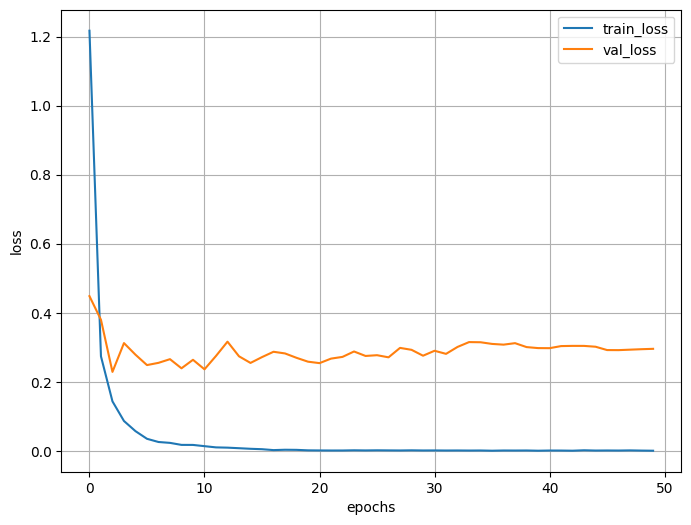

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.show()

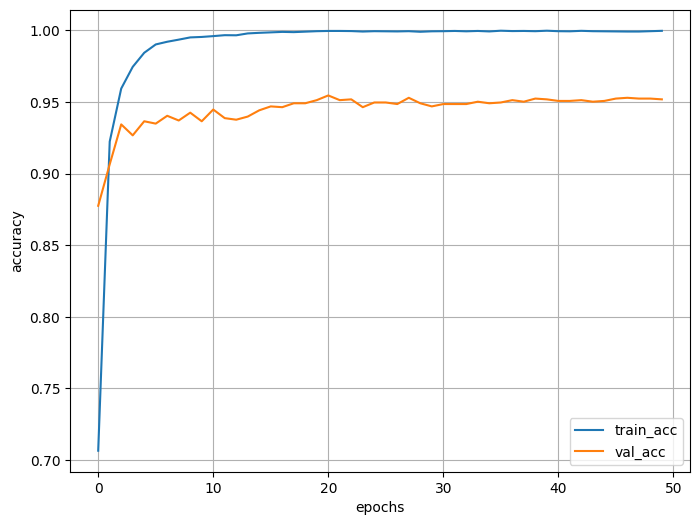

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.show()

In [16]:
vgg19_ft = copy.deepcopy(vgg19.features[:11])
vgg19_ft

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [17]:
torch.save(vgg19_ft.state_dict(), Path(str(DATA_DIR) + str('/vgg19.pth'))) # Сохраняем веса первых 11-ти слоев

In [18]:
# загрузка весов
vgg19_ft.load_state_dict(torch.load(Path(str(DATA_DIR) + str('/vgg19.pth')), map_location=torch.device('cuda')))
vgg19_ft.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)